In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm


/usr/local/lib/python3.10/dist-packages/torch_xla/__init__.py:253: UserWarning: `tensorflow` can conflict with `torch-xla`. Prefer `tensorflow-cpu` when using PyTorch/XLA. To silence this warning, `pip uninstall -y tensorflow && pip install tensorflow-cpu`. If you are in a notebook environment such as Colab or Kaggle, restart your notebook runtime afterwards.
  warnings.warn(


### Retrieveing the abstract

In [ ]:
import zipfile

# Unzip file
with zipfile.ZipFile('/content/drive/MyDrive/pdf_json.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/extract')



In [ ]:
%%time
'''extracting abstract from the json'''
import os
import json
import pandas as pd
import multiprocessing as mp
from multiprocessing import Pool

# Function to convert JSON to text
def json2text(filename):
    with open(filename, 'r') as file:
        paper_content = json.load(file)

    abstract = ""
    # Get the abstract
    if 'abstract' in paper_content:
        for abs in paper_content['abstract']:
            abstract += abs['text']

    return (f'{abstract}').lower()

# Function to write converted text to file
def write_file(filename):
    # Convert JSON to text
    content = json2text(filename)

    # Define the output file path
    base_name = os.path.splitext(os.path.basename(filename))[0]
    output_dir = '/content/pdf_text'  # desired output directory
    os.makedirs(output_dir, exist_ok=True)  # Ensure the output directory exists
    output_file = os.path.join(output_dir, f'{base_name}.txt')

    # Writing the content to a .txt file
    with open(output_file, 'w') as file:
        file.write(content)

# Function for parallel processing
def par_write(files):
    """
    Read a chunk of files and let the cores of your machine
    do the job of format conversion in parallel
    """
    cpu_count = os.cpu_count()
    p = Pool(processes=cpu_count)
    p.map(write_file, files, chunksize=16)
    p.close()

# Directory path for JSON files
dir_path = '/content/extract/pdf_json'

# List all JSON files in the directory
json_files = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith('.json')]

# Process the files in parallel
par_write(json_files)


CPU times: user 3.7 s, sys: 371 ms, total: 4.07 s
Wall time: 1min 6s


In [ ]:
# Delete the folder and its contents using shell command
!rm -rf /content/extract

In [ ]:
def remove_urls(text):
  '''removes all urls and email ids using regular expression'''

  url_pattern = r'https?://\S+|www\.\S+'
  email_id_pattern=r"\S*@\S*\s?"
  clean_text=re.sub(url_pattern, '', text)
  clean_text=re.sub(email_id_pattern, '', clean_text)

  return clean_text

def remove_single_letters(text):
  '''removes all single letters except a '''
  single_letters= r'\b[b-zB-Z]\b'
  cleaned_text = re.sub(single_letters, '', text)
  return cleaned_text

def remove_brackets(text):
    '''Removes text inside brackets '''
    return re.sub(r'\(.*?\)', '', text)

def remove_num_spl_char(text):
  '''removes all numeric and special characters'''
  corpus_num=re.sub(r'\d+', '', text)
  return re.sub('[^\w\s]', '', corpus_num)

def remove_whitespace(text):
  '''it removes all extra whitespace'''
  return " ".join(text.split())


In [ ]:
%%time
import os
import re
from multiprocessing import Pool

def preprocess(text):

    rem_urls=remove_urls(text)
    rem_bracket_ct=remove_brackets(rem_urls)
    rem_num_spl_char=remove_num_spl_char(rem_bracket_ct)
    rem_singlechar=remove_single_letters(rem_num_spl_char)
    cleaned_text=remove_whitespace(rem_singlechar)

    return cleaned_text

def preprocess_file(filename):
    """
    Read the content of a file, preprocess it, and save the cleaned text back to the file.
    """
    with open(filename, 'r') as file:
        text = file.read()
          # Preprocess text
    content = preprocess(text)

    with open(filename, 'w') as file:
        file.write(content)

def par_write(files):
    """
    Process a list of files in parallel and save the cleaned text back to the files.
    """
    cpu_count = os.cpu_count()
    p = Pool(processes=cpu_count)
    p.map(preprocess_file, files, chunksize=50)
    p.close()

# Example usage
dir_path = '/content/pdf_text'
txt_files = [os.path.join(dir_path, f) for f in os.listdir(dir_path) if f.endswith('.txt')]
par_write(txt_files)


CPU times: user 1.65 s, sys: 149 ms, total: 1.8 s
Wall time: 15.2 s


In [ ]:
from tqdm import tqdm

file_contents = []

for file_path in tqdm(txt_files, desc="Reading files"):
    try:
        with open(file_path, 'r') as f:
            content = f.read().strip()  # Remove leading/trailing whitespace
            if content:  # Only add non-empty content
                file_contents.append(content)
                if len(file_contents) == 38000:  # Stop after 500 non-empty files
                    break
    except Exception as e:
        print(f"An error occurred while reading {file_path}: {e}")

# Now `file_contents` contains the content of up to 500 non-empty files
print(f"Total non-empty files read: {len(file_contents)}")

# Optionally, write the content to a file
dir = "/content/Abstract_corpus.txt"
with open(dir, 'w') as output_file:
    for content in file_contents:
        output_file.write(content + "\n")



Reading files:  99%|█████████▉| 56043/56528 [00:01<00:00, 42157.25it/s]


Total non-empty files read: 38000


# Creating Dataset for training

In [ ]:
with open(dir,'r') as f:
    corpus=f.read().split("\n")

In [ ]:
pip install nltk

In [ ]:
corpus[0]

'we study the problem usually referred to as group testing in the context of covid given samples collected from patients how should we select and test mixtures of samples to maximize information and minimize the number of tests group testing is a wellstudied problem with several appealing solutions but recent biological studies impose practical constraints for covid that are incompatible with traditional methods furthermore existing methods use unnecessarily restrictive solutions which were devised for settings with more memory and compute constraints than the problem at hand this results in poor utility in the new setting we obtain strong solutions for small values of using evolutionary strategies we then develop a new method combining bloom filters with belief propagation to scale to larger values of with good empirical results we also present a more accurate decoding algorithm that is tailored for specific covid settings this work demonstrates the practical gap between dedicated alg

In [ ]:
import torch
import torch.nn as nn
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
import nltk
nltk.download('punkt_tab')
from nltk.tokenize import word_tokenize

tokens = [word_tokenize(abstract.lower()) for abstract in corpus]  # Tokenize each abstract and convert to lowercase
corpus_txt = [token for sublist in tokens for token in sublist]  # Flatten the list


[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
word_to_idx = {}
idx_to_word = {}
for i, word in enumerate(corpus_txt):
    if word not in word_to_idx:
        word_to_idx[word] = i
        idx_to_word[i] = word

vocab_size = len(word_to_idx)

In [ ]:
input_list = []
target_list = []

for i in range(vocab_size - 10):
    input_list.append([word_to_idx[word] for word in corpus_txt[i:i + 10]])
    target_list.append(word_to_idx[corpus_txt[i + 10]])



In [ ]:
for idx in input_list[19]:
    print(idx_to_word[idx])


patients
how
should
we
select
and
test
mixtures
of
samples


In [ ]:
input_list = torch.tensor(input_list).to(device)
target_list = torch.tensor(target_list).to(device)

# Assignment 6 - Architecture and describe the architecture

In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(BiLSTM, self).__init__()
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, 128)

        self.lstm = nn.LSTM(128, hidden_size, 2, bidirectional=True)

        self.fc = nn.Linear(hidden_size*2, output_size)

    def forward(self, input_seq):

        x = self.embedding(input_seq)  # (batch_size, seq_len, embed_dim=128)


        lstm_out, new_hidden_state = self.lstm(x.permute(1, 0, 2))  # (seq_len, batch_size, hidden_size * 2)


        forward_hidden = new_hidden_state[-2][0]  # Forward hidden state from the last layer
        backward_hidden = new_hidden_state[-1][0]  # Backward hidden state from the last layer


        combined_hidden = (forward_hidden + backward_hidden) / 2  # (batch_size, hidden_size)


        output = self.fc(combined_hidden)  # (batch_size, output_size)

        return output,new_hidden_state



### Architecture:


*   The first layer is an embedding layer that maps the input sequence of discrete tokens (e.g., word indices) into dense vector representations of size 128.
  *  Input shape: (batch_size, seq_len)
  *  Output shape: (batch_size, seq_len, embed_dim=128)
*    BiLSTM Layer (nn.LSTM): a bidirectional LSTM layer. It takes as input the embedded sequences and learns both forward and backward temporal dependencies in the data.
  * The LSTM is configured with:
    * An input size of 128 (matching the embedding size).
    * A hidden state size of hidden_size.
    * 2 layers (stacked LSTMs).
  * Output shape:
   * LSTM output: (seq_len, batch_size, hidden_size * 2) (concatenation of forward and backward states at each time step).
* A linear layer maps the combined hidden representation to the desired output size (output_size).
Input shape: (batch_size, hidden_size)
Output shape: (batch_size, output_size)
* Returns:
  * output: The final prediction logits of shape (batch_size, output_size).
  * new_hidden_state: The updated hidden state of the LSTM, useful for further computation or recurrent tasks.

# Assignment 7: Training and plotting

In [ ]:
def train(model,input_l,target_l):

  batch_size=120
  n_batches=len(input_l)//batch_size
  if len(input_l)%batch_size!=0:
      n_batches+=1


  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

  total_loss=0.0
  for i in range(n_batches):
      input=input_l[i*batch_size:(i+1)*batch_size]
      label=target_l[i*batch_size:(i+1)*batch_size]
      output,_=model(input)
      loss=criterion(output, label)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      total_loss+=loss.item()

  return total_loss/n_batches



In [ ]:
epochs=20
loss=[]
input_size=vocab_size
output_size=vocab_size
hidden_size=128

model=BiLSTM(input_size, output_size, hidden_size).to(device)
for i in range(epochs):
  loss.append(train(model,input_list,target_list))
  print(f"Epoch {i+1}/{epochs}, Loss: {loss[-1]}")

Epoch 1/20, Loss: 7.534766444465182
Epoch 2/20, Loss: 6.911831600934464
Epoch 3/20, Loss: 6.79532502502795
Epoch 4/20, Loss: 6.663064009306447
Epoch 5/20, Loss: 6.525866389116704
Epoch 6/20, Loss: 6.3817294613415045
Epoch 7/20, Loss: 6.268062424343943
Epoch 8/20, Loss: 6.186849839797873
Epoch 9/20, Loss: 6.073003002823583
Epoch 10/20, Loss: 5.987416133501672
Epoch 11/20, Loss: 5.919863439395728
Epoch 12/20, Loss: 5.856034007609285
Epoch 13/20, Loss: 5.8086378422793965
Epoch 14/20, Loss: 5.762180236633251
Epoch 15/20, Loss: 5.736493552757414
Epoch 16/20, Loss: 5.700396503675853
Epoch 17/20, Loss: 5.684711731506499
Epoch 18/20, Loss: 5.663299322759868
Epoch 19/20, Loss: 5.6406913861533665
Epoch 20/20, Loss: 5.628498155391769


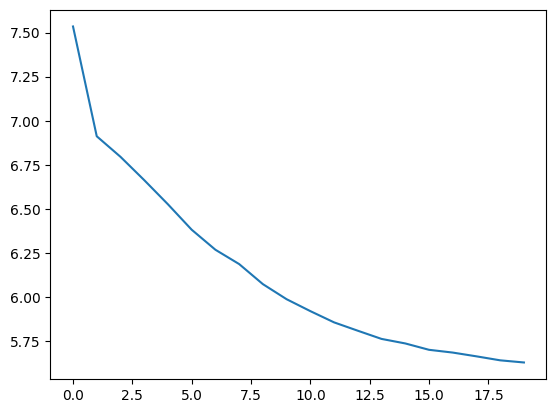

In [ ]:
import matplotlib.pyplot as plt
plt.plot(loss)

# Assignment 8: Abstract Generation

In [ ]:
def test_seq2(model, word_to_idx, idx_to_word, text, test_len, seq_len, device, temperature=1.0):
    '''
    model: Trained BiLSTM model
    word_to_idx: Dictionary mapping words to indices
    idx_to_word: Dictionary mapping indices to words
    text: Initial seed text
    test_len: Number of words to generate
    seq_len: Length of input sequence expected by the model
    device: The device to run the model on ('cpu' or 'cuda')
    temperature: Controls the randomness of predictions (higher = more random)
    '''

    model.eval()
    generated_text = text


    tokens = text.split()
    input_seq = [word_to_idx[token] for token in tokens if token in word_to_idx]  # Filter valid tokens


    if not input_seq:
        raise ValueError("Seed text contains no valid words from the vocabulary.")

    # Truncate or pad the sequence to `seq_len`
    input_seq = input_seq[-seq_len:]
    input_tensor = torch.tensor(input_seq).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        for _ in range(test_len):
            # Pass the input sequence through the model
            test_output, _ = model(input_tensor)

            # Apply temperature scaling
            logits = test_output.squeeze(0) / temperature
            probs = torch.softmax(logits, dim=-1)

            # Sample a word index from the probability distribution
            predicted_idx = torch.multinomial(probs, 1).item()

            # Get the predicted word
            if predicted_idx not in idx_to_word:
                # If somehow the index is invalid, skip
                continue
            predicted_word = idx_to_word[predicted_idx]

            # Append the predicted word to the generated text
            generated_text += ' ' + predicted_word

            # Update the input sequence:
            input_seq = input_seq[1:] + [predicted_idx]
            input_tensor = torch.tensor(input_seq).unsqueeze(0).to(device)  # Update tensor

    return generated_text


In [ ]:
test_seq2(model, word_to_idx, idx_to_word, "impact of covid", 100, 10, 'cuda', temperature=1.0)

'impact of covid patients more than could account for who th or experts in this we found significant differences with a sarscov test adverse distinct environment this observation may be to reduce the integration inhibition of severe acute respiratory tract andor time the value of the guiding members to draw conclusions prrsv plp belongs to virus surveillance for a result during recombination acts and the ai system status of complex note the continuous co monitoring which by cml patients with emphasis on transcription the epidemiology requirements of protection against on critical infection analyses enhanced loss will be reliably detected in a result were'

In [ ]:
test_seq2(model, word_to_idx, idx_to_word,"outbreak of ",100,10, 'cuda', temperature=1.0)

'outbreak of  the new dynamics in two stage the main management of the united states taking a positive cases after even though the present low monitoring practices and we find that affect the triggered similar to their corresponding can be among humans subjects with a preliminary consumers income with covid sarscov less tightly and viruses such as well understood a large abstract recommendations knowledge in the molecular virus spreads of expenses leading to increase aortic severe acute respiratory syndrome patient presented exposures despite for people in covid positive result of the face of the average gene encoding in the accuracy of per'

In [ ]:
test_seq2(model,word_to_idx, idx_to_word,"with increasing patients",100,10, 'cuda', temperature=1.0)

'with increasing patients admitted to intensive care unit resources services and not operating by rtpcr when involve level five lack of available was not observed may represent the most coronary artery disease all the outside of infections andor being predominantly clinical ejecta deposits surrounding and aa carboxyterminal end employing decoding of samples on the patient animal bodies to controls and infection and pe of symptoms which can be to help offset among healthcare environment is often to give at baseline than to the synthesis cellmediated her shins and the presence of fusion pulmonary infection by the initial chest levels genes have to competition'

The generated results exhibit a sense of structure but could be improved with several enhancements.

Implementing a character-level LSTM instead of a word-level approach would better capture subword patterns and handle out-of-vocabulary tokens.

Additionally, the corpus, despite preprocessing (e.g., removing URLs and emails), still contains nonsensical words like "der," highlighting the need for more rigorous cleaning.

Using only the last hidden states of the LSTM, while computationally efficient and memory-friendly due to resource limitations, sacrifices the ability to capture the full sequence dynamics. Ideally, the entire LSTM sequence output should be utilized to better represent the context across the input.

To maintain continuity during training, datasets were constructed by concatenating abstracts. However, this approach introduces the risk of generating words that, are wrongly declared contextually relevant.

Finally, training could have been extended over more epochs to improve results, but GPU limitations restricted the duration. Addressing these limitations could significantly enhance the quality of the generated results.